# Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import h5py
import scipy.stats as stat

%matplotlib inline

In [2]:
savePlots = True    # whether or not to save plots
saveData  = True

saveAsPath = './Fig 01/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Twitches_from_notes_'

## paths for data files

In [3]:
birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['5 LEEGf-LEEGp', '6 LEEGm-LEEGp'],
                     ['5 LEEGf-LEEGm'], #, '4 LEEGf-Fgr'] this channel seems to have too much artifact
                     ['6LEEGm-LEEGp', '9REEGm-REEGp'],
                     ['9REEGf-REEGp', '6LEEGm-LEEGf'],
                     ['4LEEGf-LEEGp','7REEGf-REEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'


## Formatting

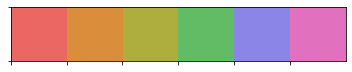

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

In [5]:
sns.set_context("notebook", font_scale=1)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

In [6]:
# Plot formatting
axis_label_fontsize=24


In [7]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

birds = ['Bird 1', 'Bird 2', 'Bird 3', 'Bird 4', 'Bird 5']

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

### color for each bird

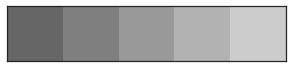

In [8]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)

# Load scores data from pre-formatted csv

In [9]:
AllScores = {}
for b_name in birds:
    scores_file = formatted_scores_path + 'All_scores_' + b_name + '.csv'
    scores = pd.read_csv(scores_file, index_col=0)
    AllScores[b_name] = scores

## Get lights on/off times

In [10]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num, b_name in enumerate(birds):

    # Calc lights off & on using datetime formats
    data = AllScores[b_name]
    startDatetime = np.datetime64(data.index[0])
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

# Get time of day for lights on and off
lightsOffTime = lightsOffDatetime.astype('datetime64[s]') - lightsOffDatetime.astype('datetime64[D]')
lightsOnTime  = lightsOnDatetime.astype('datetime64[s]')  - lightsOnDatetime.astype('datetime64[D]')

# Define functions

## loadExcelNotes

In [11]:
def loadExcelNotes(bird_num):
    bird_name = 'Bird ' + str(bird_num+1)
    video_file = birdPaths[bird_num] + video_excel_files[bird_num]
    scores = AllScores[bird_name]
    nSheets = all_nSheets[bird_num]

    # Get sheet names
    excel_file = pd.ExcelFile(video_file)
    sheet_names = excel_file.sheet_names 

    # Go through all sheets and read data
    Notes = pd.DataFrame([], columns=['Time', 'Notes', 'Recording time'])
    for s in range(nSheets):
        video_data = pd.read_excel(video_file, sheet_names[s], skiprows=[0,1,3])

        datetime_columns = [x for x in video_data.columns if 'TIME' in x]
        notes_columns = [x for x in video_data.columns if 'Unnamed' in x]
        rec_time_columns = [x for x in video_data.columns if 'HOURS' in x]

        for n, col in enumerate(datetime_columns):
            tmp_notes = video_data[notes_columns[n]]
            tmp_datetimes = video_data[col]
            tmp_rec_times = video_data[rec_time_columns[n]]
            tmp_df = pd.DataFrame({'Time': tmp_datetimes, 'Notes': tmp_notes, 'Recording time': tmp_rec_times})
            Notes = Notes.append(tmp_df)
            
    ### Convert time of day to datetime ###
    # Get days of recording
    start_datetime = np.datetime64(scores.index.values[0]) - np.timedelta64(6, 's')

    start_day = start_datetime.astype('datetime64[D]')
    second_day = start_day + np.timedelta64(1, 'D')

    # Find midnight

    video_data_times = Notes['Time'].values
    ind_midnight = np.where(video_data_times.astype('str') == '1900-01-01 00:00:00')[0][0]

    datetimes = np.zeros_like(Notes['Time'].values)

    # have to do this in a for-loop because the native datetime formats won't 
    # convert to each other in this instance unless it's one by one
    for n, t in enumerate(Notes['Time'].values):   
        if not (str(t)=='nan')|(str(t)=='NaT'):
            if type(t) == datetime.datetime:
                time_of_day = pd.Timedelta(str(t.time()))
            elif type(t) == datetime.time:
                time_of_day = pd.Timedelta(str(t))
            elif type(t) == pd._libs.tslibs.timestamps.Timestamp:
                time_of_day = pd.Timedelta(str(t.time()))
            else:
                print('time format not recognized:', n, t)
                time_of_day = str(t)


        if n < ind_midnight:
            datetimes[n] = time_of_day + start_day
        else:
            datetimes[n] = time_of_day + second_day

    Notes['Datetime'] = datetimes
    
    ### Drop rows without a note ###

    Notes = Notes.dropna()

    # Reindex
    Notes = Notes.reset_index()

    ### Add columns for Score and Score datetimes ###

    arf_datetimes = scores.index.values.astype('datetime64')

    excel_datetimes = Notes['Datetime'].values.astype('datetime64[s]')

    ### Align excel-derived datetimes with arf-derived datetimes ###

    score_datetimes = list(np.zeros(len(excel_datetimes)))
    scores_column   = list(np.zeros(len(excel_datetimes)))

    for n, timestamp in enumerate(excel_datetimes):
        ind = np.where(arf_datetimes >= timestamp)[0]

        if ind.size > 0:
            ind = ind[0]
            score_datetimes[n] = arf_datetimes[ind]
            scores_column[n] = scores['Label'].iloc[ind]

    # Add to dataframe
    Notes['Score datetimes'] = score_datetimes
    Notes['Score'] = scores_column
    
    return(Notes)

## assignArrowNotes

In [12]:
def assignArrowNotes(bird_num):
    bird_name = 'Bird ' + str(bird_num+1)
    #print(bird_name)
    Notes = AllNotes[bird_name].copy()

    arrowshaft_inds = np.where((Notes['Notes']=='|') | (Notes['Notes']=='v'))[0]

    if arrowshaft_inds.size > 0:
        for n, ind in enumerate(arrowshaft_inds):
            index_Notes = Notes.index[ind]
            if index_Notes-1 in Notes.index:
                # Change note to the one above the arrow
                new_note = Notes['Notes'].loc[index_Notes-1]
                #print(new_note)
                Notes['Notes'][index_Notes] = new_note
            else:
                print('error: no note prior to the arrow?')
                
    return(Notes)

## categorizeNotes

In [13]:
def categorizeNotes(bird_num):
    
    bird_name = 'Bird ' + str(bird_num+1)
    sleep_Notes = AllSleep_Notes[bird_name]

    ## Get a list of all unique notes
    unique_notes = np.unique(sleep_Notes['Notes'])

    ## Categorize notes (e.g. small twitches, large twitches, head droop, beak moving, etc)

    labels_twitching = [x for x in unique_notes if ('twitch' in x)|('ttwich' in x)|('twtich' in x)]
    labels_eye_movements = [x for x in unique_notes if ('eye movement' in x)|('eye movemetns' in x)|('eyes moving' in x)]
    labels_beak_movement = [x for x in unique_notes if ('beak moving' in x)|('beak movement' in x)|('call' in x)|('moving beak' in x)|('chewing' in x)|('yawn' in x)]
    labels_drooping = [x for x in unique_notes if ('moved' in x)|('tilt' in x)|('droop' in x)|('dropping' in x)]
    labels_shifting = [x for x in unique_notes if ('shift' in x)|('changed position' in x)|('changing position' in x)|('change in position' in x)|('moving' in x)|('movement' in x)|('raising head' in x)|('flexing head' in x)]
    labels_fluffing = [x for x in unique_notes if ('fluffing' in x)|('ruffling' in x)|('ruflling' in x)|('fluffling' in x)|('puffing' in x)]
    labels_eye_openings  = [x for x in unique_notes if ('eye briefly opened' in x)|('eyes briefly opened' in x)|('eye opened briefly' in x)|('brief eye opening' in x)|('closing' in x)]

    category = []

    for n,note in enumerate(sleep_Notes['Notes'].values):
        if note in labels_eye_movements:
            category.append('Eye movement')
        elif note in labels_beak_movement:
            category.append('Beak movement')
        elif note in labels_twitching:
            category.append('Twitch')
        elif note in labels_drooping:
            category.append('Drooping')
        elif note in labels_shifting:
            category.append('Shifting')
        elif note in labels_fluffing:
            category.append('Fluffing')
        elif note in labels_eye_openings:
            category.append('Brief eye openings')
        else:
            category.append('Unclassified: ' + note)

    sleep_Notes['Category'] = category
    
    return(sleep_Notes)

## summaryDataframe

In [14]:
def summaryDataframe(category):
    ## Create a summary dataframe of number of category events by stage

    allCategory_by_Stage = pd.DataFrame([], index=stage_abbr)

    for bird_num, bird_name in enumerate(birds):
        bird_name = 'Bird ' + str(bird_num+1)
        sleep_Notes = AllSleep_Notes[bird_name]
        category_Notes = sleep_Notes[sleep_Notes['Category']==category]

        if category_Notes.size > 0:
            category_Stages = category_Notes['Score'].value_counts(sort=False)
            allCategory_by_Stage[bird_name] = category_Stages

    allCategory_by_Stage = allCategory_by_Stage.sort_index().fillna(0)
    totals = allCategory_by_Stage.sum()
    
    return(allCategory_by_Stage)

## plotEventsByStage

In [15]:
def plotEventsByStage(category, summary_dataframe):
    
    plt.figure(figsize=(8,4.5))
    
    # First plot the summary bars for each stage
    for n,st in enumerate(stage_abbr):
        stage_color = colors_to_plot[n]

        average = summary_dataframe.loc[st].mean()
        plt.bar(n, average, width=1, color='none', edgecolor=stage_color, linewidth=4)
    
    # Then plot a line linking all the datapoints for each individual bird
    birds_to_plot = summary_dataframe.columns
    for bird in birds_to_plot:
        bird_num = int(bird[5]) - 1
        bird_color = colors_birds[bird_num]
        plt.plot(range(len(stage_abbr)), summary_dataframe[bird].loc[stage_abbr],
                 '-o', color=bird_color, alpha=.7)
            
    # xlabels
    plt.xticks(np.arange(0,n+1), stage_names, fontsize=20, fontweight='bold');
    ax = plt.gca()
    for xtick, color in zip(ax.get_xticklabels(), colors_to_plot):
        xtick.set_color(color)

    # other formatting
    plt.xlim(-0.7, n+.7)
    plt.ylim(-0.02*summary_dataframe.max().max(), 1.1*summary_dataframe.max().max())
    
    plt.ylabel('Number of events', fontsize=16)
    
    plt.title(category + " | n = " + str(len(summary_dataframe.columns)) + ' birds',
             fontsize=20)

# Run functions

## Load data and categorize

### Sheet names for each bird

In [40]:
video_excel_files = ['Excel final scores/BudgieFemale_green1_VideoScoring.xlsx',
                     'BudgieMale_yellow1_VideoScoring.xlsx',
                     'BudgieFemale_white1_VideoScoring.xlsx',
                     'BudgieMale_yellow2_VideoScoring.xlsx',
                     'BudgieFemale_green2_VideoScoring.xlsx']
all_nSheets = [1, 2, 1, 1, 1]

### Columns to import: datetime + notes from video, datetime + scores from stages

In [41]:
AllNotes = {}

for b_num, b_name in enumerate(birds):
    Notes = loadExcelNotes(b_num)
    AllNotes[b_name] = Notes

### Assign "arrow" notes ( | and v) to a label

In [42]:
AllSleep_Notes = {}

for b_num, b_name in enumerate(birds):
    Notes = assignArrowNotes(b_num)
    AllNotes[b_name] = Notes
    
    Notes = AllNotes[b_name].copy()
    
    AllSleep_Notes[b_name] = Notes
    

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Categorize notes 

In [43]:
for b_num, b_name in enumerate(birds):
    sleep_Notes = categorizeNotes(b_num)
    AllSleep_Notes[b_name] = sleep_Notes
    
    print('###### ' + b_name + ' ######')
    print(sleep_Notes['Category'].value_counts())

###### Bird 1 ######
Twitch                                                                  360
Beak movement                                                           206
Eye movement                                                             54
Unclassified: grooming                                                   31
Shifting                                                                 28
                                                                       ... 
Unclassified: perching, pecking                                           1
Unclassified: returned to perch                                           1
Unclassified: possbile unihem sleep - L eye closed more consistantly      1
Unclassified: pecking at mirror, turning around                           1
Unclassified: R eye open                                                  1
Name: Category, Length: 70, dtype: int64
###### Bird 2 ######
Twitch                                                            695
Unclassifie

### Plots formatting

In [44]:
# Set names and colors for each stage
stage_names = ['wake', 'drowsy', 'US', 'SWS', 'IS', 'REM'] 
stage_abbr  = ['w', 'd', 'u', 's', 'i', 'r']   # this also sets the order in which the bars are plotted
color_inds  = [0, 1, 2, 4, 3, 5]
colors_to_plot = []
for ind in color_inds:
    colors_to_plot.append(colors[ind])

## Summary bar graphs: all birds

In [45]:
categories = ['Eye movement', 'Beak movement', 'Drooping']


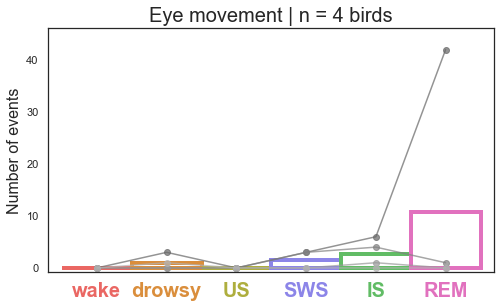

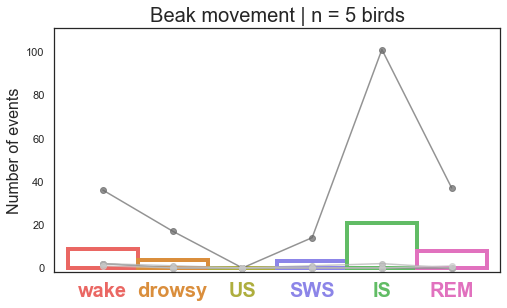

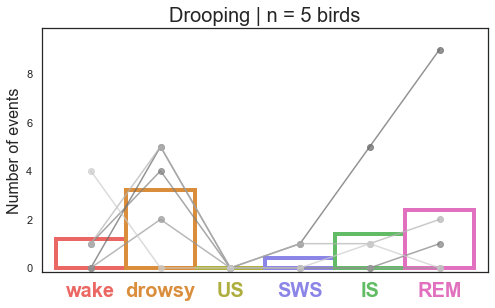

In [46]:
summary_Categories_by_Stage = {}
for category in categories:
    tmpCategory_by_Stage = summaryDataframe(category)
    plotEventsByStage(category, tmpCategory_by_Stage)
    
    # save to dict
    summary_Categories_by_Stage[category] = tmpCategory_by_Stage
    
    if savePlots:
        plt.savefig(saveAsPath + saveAsName + '_' + category + '.pdf')

### TOTAL: eye movements

In [47]:
summary_Categories_by_Stage['Eye movement']

,Bird 1,Bird 2,Bird 3,Bird 4
d,3.0,0.0,0.0,1.0
i,6.0,4.0,1.0,0.0
r,42.0,1.0,0.0,0.0
s,3.0,3.0,0.0,0.0
u,0.0,0.0,0.0,0.0
w,0.0,0.0,0.0,0.0


In [48]:
summary_Categories_by_Stage['Eye movement'].sum()

Bird 1    54.0
Bird 2     8.0
Bird 3     1.0
Bird 4     1.0
dtype: float64

### TOTAL: head drooping

In [49]:
summary_Categories_by_Stage['Drooping']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
d,5.0,4.0,2.0,5.0,0.0
i,5.0,0.0,0.0,1.0,1.0
r,9.0,1.0,0.0,2.0,0.0
s,1.0,0.0,0.0,1.0,0.0
u,0.0,0.0,0.0,0.0,0.0
w,0.0,1.0,0.0,1.0,4.0


In [50]:
test = summary_Categories_by_Stage['Drooping']

print('drooping episodes per bird')
test.sum()

drooping episodes per bird


Bird 1    20.0
Bird 2     6.0
Bird 3     2.0
Bird 4    10.0
Bird 5     5.0
dtype: float64

In [51]:
print('mean drooping episodes per bird:')
print(test.sum().mean())
print('SEM:', test.sum().std()/np.sqrt(len(test.sum())))

mean drooping episodes per bird:
8.6
SEM: 3.1240998703626617


In [52]:
test/test.sum()

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
d,0.25,0.666667,1.0,0.5,0.0
i,0.25,0.000000,0.0,0.1,0.2
r,0.45,0.166667,0.0,0.2,0.0
s,0.05,0.000000,0.0,0.1,0.0
u,0.00,0.000000,0.0,0.0,0.0
w,0.00,0.166667,0.0,0.1,0.8


In [53]:
test_perc = test/test.sum()
test_perc.mean(axis=1)

d    0.483333
i    0.110000
r    0.163333
s    0.030000
u    0.000000
w    0.213333
dtype: float64

In [54]:
print('SEMs')
test_perc.std(axis=1)/np.sqrt(len(test.sum()))

SEMs


d    0.171594
i    0.050990
r    0.082731
s    0.020000
u    0.000000
w    0.150037
dtype: float64

In [55]:
# Drooping: sleep only:
test = summary_Categories_by_Stage['Drooping'].loc[['i','s','r']]
test

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
i,5.0,0.0,0.0,1.0,1.0
s,1.0,0.0,0.0,1.0,0.0
r,9.0,1.0,0.0,2.0,0.0


In [56]:
test_perc = test/test.sum()
test_perc.mean(axis=1)

i    0.395833
s    0.079167
r    0.525000
dtype: float64

In [57]:
print('SEMs')
test_perc.std(axis=1)/np.sqrt(len(test.sum()))

SEMs


i    0.190941
s    0.052836
r    0.183938
dtype: float64

### TOTAL: beak movements

In [58]:
summary_Categories_by_Stage['Beak movement']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
d,17.0,0.0,0.0,1.0,0.0
i,101.0,0.0,0.0,2.0,0.0
r,37.0,0.0,0.0,0.0,1.0
s,14.0,0.0,0.0,1.0,0.0
u,0.0,0.0,0.0,0.0,0.0
w,36.0,2.0,2.0,2.0,1.0


In [59]:
# Drooping: sleep only:
test = summary_Categories_by_Stage['Beak movement'].loc[['i','s','r']]
test

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
i,101.0,0.0,0.0,2.0,0.0
s,14.0,0.0,0.0,1.0,0.0
r,37.0,0.0,0.0,0.0,1.0


In [60]:
test_perc = test/test.sum()
test_perc.mean(axis=1)

i    0.443713
s    0.141813
r    0.414474
dtype: float64

In [61]:
test.sum()

Bird 1    152.0
Bird 2      0.0
Bird 3      0.0
Bird 4      3.0
Bird 5      1.0
dtype: float64

## save to csv

In [62]:
if saveData:
    for category in categories:
        category_by_stage = summary_Categories_by_Stage[category]
        category_by_stage.to_csv(saveAsPath + saveAsName + str(category) + '_all.csv')

# Look only at beginning of episodes 
ie don't assign arrows

In [63]:
AllNotes = {}

for b_num, b_name in enumerate(birds):
    Notes = loadExcelNotes(b_num)
    AllNotes[b_name] = Notes

## Assign "arrow" notes ( | and v) to a label

In [64]:
AllSleep_Notes = {}

for b_num, b_name in enumerate(birds):
    #Notes = assignArrowNotes(b_num)
    #AllNotes[b_name] = Notes
    
    Notes = AllNotes[b_name].copy()
    
    AllSleep_Notes[b_name] = Notes
    
    # Get only notes during sleep stages
    #sleep_Notes = Notes[(Notes['Score'] != 'w') & (Notes['Score'] != ' w')]
    #AllSleep_Notes[b_name] = sleep_Notes

## Get notes and scores only during nighttime

for b_num, b_name in enumerate(birds):    
    # scores
    bird_scores = AllScores[b_name]
    index_datetimes = bird_scores.index.astype('datetime64[ns]')
    index_isnight = (index_datetimes >= lightsOffDatetime[b_num]) & (index_datetimes <= lightsOnDatetime[b_num])
    AllScores[b_name] = bird_scores[index_isnight]
    
    # notes
    sleep_Notes = AllSleep_Notes[b_name]
    index_datetimes = sleep_Notes.index.astype('datetime64[ns]')
    index_isnight = (index_datetimes >= lightsOffDatetime[b_num]) & (index_datetimes <= lightsOnDatetime[b_num])
    AllSleep_Notes[b_name] = sleep_Notes
    

## Categorize notes 

In [65]:
for b_num, b_name in enumerate(birds):
    sleep_Notes = categorizeNotes(b_num)
    AllSleep_Notes[b_name] = sleep_Notes
    
    print('###### ' + b_name + ' ######')
    print(sleep_Notes['Category'].value_counts())

###### Bird 1 ######
Twitch                                        291
Unclassified: |                               165
Beak movement                                  85
Eye movement                                   54
Unclassified: grooming                         31
                                             ... 
Unclassified: LIGHTS ON                         1
Unclassified: drinking?                         1
Unclassified: L eye drowsy                      1
Unclassified: perching, pecking                 1
Unclassified: L eye (facing mirror) closed      1
Name: Category, Length: 72, dtype: int64
###### Bird 2 ######
Twitch                                                            669
Unclassified: grooming                                             32
Unclassified: |                                                    29
Shifting                                                           25
Unclassified: eating                                                7
Drooping         

## Summary bar graphs: all birds

In [77]:
categories = ['Twitch']

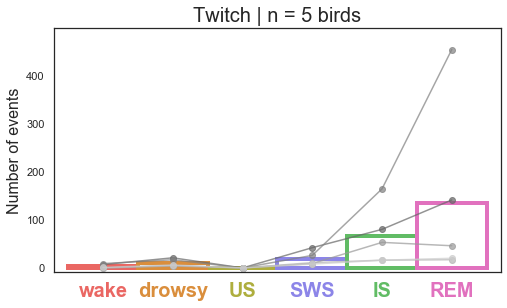

In [78]:
summary_Categories_by_Stage = {}
for category in categories:
    tmpCategory_by_Stage = summaryDataframe(category)
    plotEventsByStage(category, tmpCategory_by_Stage)
    #plt.legend()
    
    # save to dict
    summary_Categories_by_Stage[category] = tmpCategory_by_Stage
    
    if savePlots:
        plt.savefig(saveAsPath + saveAsName + '_' + category + '-episodes.pdf')

### TOTAL: twitches

In [68]:
summary_Categories_by_Stage['Twitch']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
d,21.0,17.0,5.0,4.0,6.0
i,80.0,164.0,53.0,16.0,16.0
r,141.0,453.0,46.0,17.0,20.0
s,42.0,26.0,9.0,11.0,8.0
u,0.0,0.0,0.0,0.0,0.0
w,7.0,9.0,0.0,0.0,1.0


In [69]:
# Convert to percentages
test = summary_Categories_by_Stage['Twitch']
test_perc = test/test.sum(axis=0)
test_perc

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
d,0.072165,0.025411,0.044248,0.083333,0.117647
i,0.274914,0.245142,0.469027,0.333333,0.313725
r,0.484536,0.677130,0.407080,0.354167,0.392157
s,0.144330,0.038864,0.079646,0.229167,0.156863
u,0.000000,0.000000,0.000000,0.000000,0.000000
w,0.024055,0.013453,0.000000,0.000000,0.019608


In [70]:
test_perc.mean(axis=1)

d    0.068561
i    0.327228
r    0.463014
s    0.129774
u    0.000000
w    0.011423
dtype: float64

In [71]:
# Twitching: sleep only:
test = summary_Categories_by_Stage['Twitch'].loc[['i','s','r']]
test

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
i,80.0,164.0,53.0,16.0,16.0
s,42.0,26.0,9.0,11.0,8.0
r,141.0,453.0,46.0,17.0,20.0


In [72]:
test.sum()

Bird 1    263.0
Bird 2    643.0
Bird 3    108.0
Bird 4     44.0
Bird 5     44.0
dtype: float64

In [73]:
print('mean twitching episodes per bird:')
print(test.sum().mean())
print('SEM:', test.sum().std()/np.sqrt(len(test.sum())))

mean twitching episodes per bird:
220.4
SEM: 112.97636921055658


In [74]:
test_perc = test/test.sum()
test_perc.mean(axis=1)

i    0.355450
s    0.143057
r    0.501493
dtype: float64

In [75]:
print('SEMs')
test_perc.std(axis=1)/np.sqrt(len(test.sum()))

SEMs


i    0.039462
s    0.036956
r    0.056385
dtype: float64

## save to csv

In [76]:
if saveData:
    for category in categories:
        category_by_stage = summary_Categories_by_Stage[category]
        category_by_stage.to_csv(saveAsPath + saveAsName + str(category) + '_beginnings.csv')